In [29]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from deepdiff import DeepDiff

from HANKStickyModel import HANKStickyModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Functions

In [6]:
def find_IRFs(model, model_sticky, shocks):
    # calc IRFs
    print('find IRFs (no sticky)')
    model.find_IRFs(shocks=shocks)
    if model_sticky != None:
        print('find IRFs (sticky)')
        model_sticky.find_IRFs(shocks=shocks)


def calc_jacs_IRFs(model, model_sticky=None, inattention_baseline=0.935, shocks=['eg']):
    # make sure only inattention parameter is different
    if model_sticky != None:
        assert (len(diff := DeepDiff(model.par.__dict__, model_sticky.par.__dict__)['values_changed'].keys())) == 1, diff

    print(f'Fiscal policy settings:')
    print(f'phi_G = {model.par.phi_G}')
    print(f'phi_tau = {model.par.phi_tau}')
    print(f'phi_pi = {model.par.phi_pi}')
    print(f'rho_m = {model.par.rho_m}')
    print('')

    print(f'shock settings:')
    for s in shocks:
        jump_name = 'jump_' + s
        rho_name = 'rho_' + s
        print(f'shock: {s} -> jump = {model.par.__dict__[jump_name]}, rho = {model.par.__dict__[rho_name]}')
    print('')

    # compute jacs: model without sticky information
    print('Compute Jacobians (no sticky) ')
    assert model.par.inattention == 0.0
    model._compute_jac(inputs='unknowns')
    model._compute_jac(inputs='shocks')
    # model.compute_jacs(do_print=False)
    # compute jacs: model with sticky information
    if model_sticky != None:
        print('Compute Jacobians (sticky) ')
        model_sticky.par.inattention = inattention_baseline
        model_sticky.jac_hh = deepcopy(model.jac_hh)
        model_sticky.jac_hh = model_sticky._compute_sticky_jacs_hh(model_sticky.jac_hh)
        model_sticky._compute_jac(inputs='unknowns')
        model_sticky._compute_jac(inputs='shocks')
        # model_sticky.compute_jacs(do_print=False)

    find_IRFs(model, model_sticky, shocks)


def show_only_IRFs(model, IRFs, labels, varnames,
                   abs_diff=None, lvl_value=None, facs=None, pows=None,
                   do_shocks=True, do_targets=True,
                   ncols=4, T_max=None, filename=None):
    abs_diff = [] if abs_diff is None else abs_diff
    lvl_value = [] if lvl_value is None else lvl_value
    facs = {} if facs is None else facs
    pows = {} if pows is None else pows

    par = model.par
    if T_max is None: T_max = par.T

    # full_list
    full_list = []
    if do_shocks: full_list.append(('shocks', [x for x in model.shocks]))
    full_list.append(('varnames', varnames))
    if do_targets: full_list.append(('tagets', [x for x in model.targets]))

    # default fac = 1.0
    for (typename, varnames) in full_list:
        for varname in varnames:
            if not varname in facs: facs[varname] = 1.0
            if not varname in pows: pows[varname] = 1.0

    # figures
    do_legend = any([not x is None for x in labels])
    for (typename, varnames) in full_list:

        if do_shocks or do_targets: print(f'### {typename} ###')

        num = len(varnames)
        nrows = num // ncols + 1
        if num % ncols == 0: nrows -= 1

        fig = plt.figure(figsize=(6 * ncols, 4 * nrows), dpi=100)
        for i, varname in enumerate(varnames):

            ax = fig.add_subplot(nrows, ncols, i + 1)
            title = varname
            if not np.isclose(pows[varname], 1.0): title += (' (ann.)')
            ax.set_title(title, fontsize=14)

            for label, IRF_ in zip(labels, IRFs):

                # pathvalue = model_.path.__dict__[varname][:,0]
                IRFvalue = IRF_[varname]

                if not np.isnan(getattr(model.ss, varname)):

                    ssvalue = model.ss.__dict__[varname]
                    IRFvalue = IRFvalue + ssvalue

                    if varname in lvl_value or varname in model.targets:

                        if np.isclose(ssvalue, 1.0):
                            IRFvalue = facs[varname] * IRFvalue ** pows[varname]
                        else:
                            IRFvalue = facs[varname] * ((1 + IRFvalue) ** pows[varname] - 1)

                        ax.plot(np.arange(T_max), IRFvalue[:T_max], label=label)

                        if not np.isclose(facs[varname], 1.0):
                            ax.set_ylabel(fr'{facs[varname]:.0f} x level')
                        else:
                            ax.set_ylabel('')

                    elif varname in abs_diff:

                        if np.isclose(ssvalue, 1.0):
                            ssvalue = facs[varname] * ssvalue ** pows[varname]
                            IRFvalue = facs[varname] * IRFvalue ** pows[varname]
                        else:
                            ssvalue = facs[varname] * ((1 + ssvalue) ** pows[varname] - 1)
                            IRFvalue = facs[varname] * ((1 + IRFvalue) ** pows[varname] - 1)

                        ax.plot(np.arange(T_max), IRFvalue[:T_max] - ssvalue, label=label)

                        if varname in facs:
                            ax.set_ylabel(fr'{facs[varname]:.0f} x abs. diff. to of s.s.')
                        else:
                            ax.set_ylabel('abs. diff. to of s.s.')

                    else:

                        ax.plot(np.arange(T_max), 100 * (IRFvalue[:T_max] / ssvalue - 1), label=label)

                        ax.set_ylabel('% diff. to s.s.')

                else:

                    ax.plot(np.arange(T_max), IRFvalue[:T_max], label=label)

            if (len(labels) > 1) and i == 0: ax.legend(frameon=True)

        fig.tight_layout(pad=3.0)
        plt.show()
        print('')

        # save
        if not filename is None: fig.savefig(f'{filename}_{typename}.pdf')

In [15]:
def calc_FMP(IRF, ss_r, cum_FMP_max_T=None, do_transfers=False):
    """Calculate fiscal multiplier"""

    assert IRF['eg'].any() or IRF['eg_transfer'].any(), 'No fiscal policy shocks specified'


    dY = np.array([(1 + ss_r) ** (-t) * IRF['Y'][t] for t in range(cum_FMP_max_T + 1)])

    if do_transfers:
        dG = np.array([(1 + ss_r) ** (-t) * IRF['T'][t] for t in range(cum_FMP_max_T + 1)])
    else:
        dG = np.array([(1 + ss_r) ** (-t) * IRF['G'][t] for t in range(cum_FMP_max_T + 1)])

    assert dG.sum() != 0.0, 't=0, G == 0 -> divide error in fiscal multiplier'

    fmp_cum = dY[:cum_FMP_max_T + 1].sum() / dG[:cum_FMP_max_T + 1].sum()

    return fmp_cum

In [18]:
def plot_Y_C_FMPs(IRFs_thetas, do_transfers, ss=model.ss, T_max=40):
    ncols = 3
    nrows = 1

    theta_list = IRFs_thetas.keys()

    fig = plt.figure(figsize=(6 * ncols, 4 * nrows), dpi=100, clear=True)

    ax0 = fig.add_subplot(nrows, ncols, 1)
    ax0.set_title('Output')
    ax0.set_xlabel('Quarters')
    ax0.set_ylabel('% diff. to s.s.')
    ax0.set_xlim(0, T_max - 1)

    for theta in theta_list:
        ax0.plot(np.arange(T_max), IRFs_thetas[theta]['Y'][:T_max] / ss.Y * 100, label=f'$\\theta = {theta}$')
    ax0.legend()

    ax1 = fig.add_subplot(nrows, ncols, 2)
    ax1.set_title('Consumption')
    ax1.set_xlabel('Quarters')
    ax1.set_ylabel('% diff. to s.s.')
    ax1.set_xlim(0, T_max - 1)

    for theta in theta_list:
        ax1.plot(np.arange(T_max), IRFs_thetas[theta]['C_hh'][:T_max] / ss.C_hh * 100, label=f'$\\theta = {theta}$')
    # ax1.legend()

    ax = fig.add_subplot(nrows, ncols, 3)
    for theta in theta_list:
        fmps = [calc_FMP(IRFs_thetas[theta], ss.r, cum_FMP_max_T=t, do_transfers=do_transfers) for t in range(T_max)]
        ax.plot(np.arange(T_max), fmps, label=f'$\\theta = {theta}$')
    ax.set_title('Fiscal Multiplier')
    ax.set_xlabel('t (in quarters)')
    ax.set_ylabel('cumulative FMP')
    ax.set_xlim([0, T_max - 1])
    # ax.legend()

In [21]:
def plot_decomp_C(jac_hh, IRF, ss, T_max=model.IRF['Y'].shape[0], return_dC = True, ax=None, do_transfer=False):
    dC_tau = jac_hh[('C_hh', 'tau')] @ IRF['tau']
    dC_wN = jac_hh[('C_hh', 'wN')] @ IRF['wN']
    dC_rl = jac_hh[('C_hh', 'rl')] @ IRF['rl']
    dC_ra = jac_hh[('C_hh', 'ra')] @ IRF['ra']
    dC_Z = jac_hh[('C_hh', 'wN')] @ IRF['wN'] + jac_hh[('C_hh', 'tau')] @ IRF['tau']
    dC_T = jac_hh[('C_hh', 'eg_transfer')] @ IRF['eg_transfer']
    dC_full = IRF['C_hh']
    # assert np.isclose(dC_tau + dC_wN + dC_rl + dC_ra, dC_full).all()
    assert np.isclose(dC_Z + dC_rl + dC_ra + dC_T, dC_full).all()
    # ax.plot(np.arange(T_max), dC_tau[:T_max]/ss.C_hh*100, label='tau', ls='--')
    # ax.plot(np.arange(T_max), dC_wN[:T_max]/ss.C_hh*100, label='wN', ls='--')
    if ax != None:
        ax.plot(np.arange(T_max), dC_Z[:T_max]/ss.C_hh*100, label='Z', ls='--')
        ax.plot(np.arange(T_max), dC_rl[:T_max]/ss.C_hh*100, label='rl', ls='--')
        ax.plot(np.arange(T_max), dC_ra[:T_max]/ss.C_hh*100, label='ra', ls='--')
        ax.plot(np.arange(T_max), dC_full[:T_max]/ss.C_hh*100, label='full')
        if do_transfer:
            ax.plot(np.arange(T_max), dC_T[:T_max]/ss.C_hh*100, label='T', ls='--')

    if return_dC:
        return dC_full, dC_tau, dC_wN, dC_rl, dC_ra, dC_Z, dC_T



In [22]:
def plot_decomp_by_thetas(IRF_thetas, jacs_hh_thetas, ss=model.ss, T_max=40, do_transfer=False):
    ncols = 3
    nrows = 1
    fig = plt.figure(figsize=(6*ncols,4*nrows),dpi=100, clear=True)

    ax1 = fig.add_subplot(nrows,ncols,1)
    ax1.set_title('Difference in consumption: dC($\\theta$) - dC(0)')
    ax1.set_xlabel('Quarters')
    ax1.set_ylabel('% diff. to $C^{ss}$')
    ax1.set_xlim(0,T_max-1)

    theta_list = IRF_thetas.keys()

    for theta in theta_list:
        ax1.plot(np.arange(T_max), (IRF_thetas[theta]['C_hh'][:T_max]-IRF_thetas[0.0]['C_hh'][:T_max])/ss.C_hh*100, label=f'$\\theta = {theta}$')
    ax1.legend()

    ax2 = fig.add_subplot(nrows,ncols,2)
    ax2.set_title('Sticky information effect: $dC_{t}^{P.E.}$')
    ax2.set_xlabel('Quarters')
    # ax2.set_ylabel('% diff. to C s.s.')
    ax2.set_xlim(0,T_max-1)

    ax3 = fig.add_subplot(nrows,ncols,3)
    ax3.set_title('General equilibrium effect: $dC_{t}^{G.E.}$')
    ax3.set_xlabel('Quarters')
    # ax3.set_ylabel('% diff. to C s.s.')
    ax3.set_xlim(0,T_max-1)

    keys = [('C_hh', 'tau'), ('C_hh', 'wN'), ('C_hh', 'rl'), ('C_hh', 'ra')]
    if do_transfer:
        keys += [('C_hh', 'eg_transfer')]
    jac_hh = jacs_hh_thetas[0.0]
    IRF = IRF_thetas[0.0]
    for theta in theta_list:
        jac_hh_sticky = jacs_hh_thetas[theta]
        IRF_sticky = IRF_thetas[theta]
        dC_sticky = np.array([(jac_hh_sticky[key] - jac_hh[key]) @ IRF[key[1]] for key in keys]).sum(axis=0)
        dC_indirect = np.array([jac_hh_sticky[key] @ (IRF_sticky[key[1]] - IRF[key[1]]) for key in keys]).sum(axis=0)
        assert np.isclose(IRF_sticky['C_hh'] - (IRF['C_hh'] + dC_sticky + dC_indirect), 0.0).all()
        # ax1.plot(np.arange(T_max), IRF['C_hh'][:T_max], label='no sticky total')
        # ax1.plot(np.arange(T_max), IRF_sticky['C_hh'][:T_max], label='sticky total')
        ax2.plot(np.arange(T_max), dC_sticky[:T_max]/ss.C_hh*100, label=f'$\\theta={theta}$', ls='-')
        ax3.plot(np.arange(T_max), dC_indirect[:T_max]/ss.C_hh*100, label=f'$\\theta={theta}$', ls='-')


    ax2.legend()
    ax3.legend()

    fig.tight_layout()


In [23]:
def plot_decomp_by_inputs(IRFs_theta, jacs_hh_thetas, theta, ss=model.ss, T_max=40, do_transfer=False, base_theta = 0.0, use_Z=True):

    IRF = IRFs_theta[base_theta]
    IRF_sticky = IRFs_theta[theta]

    jac_hh = jacs_hh_thetas[base_theta]
    jac_hh_sticky = jacs_hh_thetas[theta]


    ncols = 3
    nrows = 1
    fig = plt.figure(figsize=(6*ncols,4*nrows),dpi=100, clear=True)

    ax1 = fig.add_subplot(nrows,ncols,1)
    ax1.set_title(f'$C(\\theta={theta})$ - $C(\\theta={base_theta})$')
    ax1.set_xlabel('Quarters')
    ax1.set_ylabel('% diff. to $C^{ss}$')
    ax1.set_xlim(0,T_max-1)


    dC_full, dC_tau, dC_wN, dC_rl, dC_ra, dC_Z, dC_T = plot_decomp_C(jac_hh, IRF, ss, T_max=T_max, do_transfer=do_transfer)
    dC_full_sticky, dC_tau_sticky, dC_wN_sticky, dC_rl_sticky, dC_ra_sticky, dC_Z_sticky, dC_T_sticky = plot_decomp_C(jac_hh_sticky, IRF_sticky, ss, T_max=T_max, do_transfer=do_transfer)

    labels = {'Z': '$Z$',
              'wN': '$wN$',
              'tau': '$\\tau$',
              'rl': '$r^{\\ell}$',
              'ra': '$r^a$',
              'eg_transfer': '$T$'}

    diff_Z = dC_Z_sticky[:T_max]-dC_Z[:T_max]
    if use_Z:
        ax1.plot(np.arange(T_max), diff_Z, label='Z', ls='--')
    else:
        ax1.plot(np.arange(T_max), diff_tau := dC_tau_sticky[:T_max]-dC_tau[:T_max], label='$\\tau$', ls='--')
        ax1.plot(np.arange(T_max), diff_wN := dC_wN_sticky[:T_max]-dC_wN[:T_max], label='$WN$', ls='--')
    ax1.plot(np.arange(T_max), diff_rl := dC_rl_sticky[:T_max]-dC_rl[:T_max], label='$r^{\\ell}$', ls='--')
    ax1.plot(np.arange(T_max), diff_ra := dC_ra_sticky[:T_max]-dC_ra[:T_max], label='$r^a$', ls='--')
    diff_T = dC_T_sticky[:T_max]-dC_T[:T_max]
    if do_transfer:
        ax1.plot(np.arange(T_max), diff_T, label='T', ls='--')
    ax1.plot(np.arange(T_max), diff_full := dC_full_sticky[:T_max]-dC_full[:T_max], label='Sum')
    assert np.isclose(diff_full, diff_Z+diff_rl+diff_ra+diff_T).all()
    ax1.legend()

    ax2 = fig.add_subplot(nrows,ncols,2)
    ax2.set_title('Sticky information effect')
    ax2.set_xlabel('Quarters')
    # ax2.set_ylabel('% diff. to C s.s.')
    ax2.set_xlim(0,T_max-1)

    ax3 = fig.add_subplot(nrows,ncols,3)
    ax3.set_title('General equilibrium effect')
    ax3.set_xlabel('Quarters')
    # ax3.set_ylabel('% diff. to C s.s.')
    ax3.set_xlim(0,T_max-1)


    dC_dict = {'Z': dC_Z,
               'tau': dC_tau,
               'wN': dC_wN,
                'rl': dC_rl,
                'ra': dC_ra,
               'eg_transfer': dC_T,
               'Sum': dC_full}
    dC_dict_sticky = {'Z': dC_Z_sticky,
                      'tau': dC_tau_sticky,
                      'wN': dC_wN_sticky,
                'rl': dC_rl_sticky,
                'ra': dC_ra_sticky,
                'eg_transfer': dC_T_sticky,
                'Sum': dC_full_sticky}

    dC_sticky_full = np.zeros(model.par.T)
    dC_indirect_full = np.zeros(model.par.T)
    keys = []
    if use_Z:
        keys += [('C_hh', 'Z')]
    else:
        keys += [('C_hh', 'tau'), ('C_hh', 'wN')]
    keys += [('C_hh', 'rl'), ('C_hh', 'ra')]
    if do_transfer:
        keys += [('C_hh', 'eg_transfer')]
    for key in keys:
        if key[1] == 'Z':
            dC_sticky = np.array([(jac_hh_sticky[k] - jac_hh[k]) @ IRF[k[1]] for k in [('C_hh', 'tau'), ('C_hh', 'wN')]]).sum(axis=0)
            dC_indirect = np.array([jac_hh_sticky[k] @ (IRF_sticky[k[1]] - IRF[k[1]]) for k in [('C_hh', 'tau'), ('C_hh', 'wN')]]).sum(axis=0)
        else:
            dC_sticky = (jac_hh_sticky[key] - jac_hh[key]) @ IRF[key[1]]
            dC_indirect = jac_hh_sticky[key] @ (IRF_sticky[key[1]] - IRF[key[1]])
        assert np.isclose(dC_dict_sticky[key[1]] - (dC_dict[key[1]] + dC_sticky + dC_indirect), 0.0).all()

        dC_sticky_full += dC_sticky
        dC_indirect_full += dC_indirect

        label = labels[key[1]]

        ax2.plot(np.arange(T_max), dC_sticky[:T_max]/ss.C_hh*100, label=f'{label}', ls='--')
        ax3.plot(np.arange(T_max), dC_indirect[:T_max]/ss.C_hh*100, label=f'{label}', ls='--')

        dC_frac_sticky = dC_sticky.sum() / (dC_dict_sticky[key[1]] - dC_dict[key[1]]).sum()
        dC_frac_indirect = dC_indirect.sum() / (dC_dict_sticky[key[1]] - dC_dict[key[1]]).sum()
        dC_frac_abs = dC_sticky.__abs__().sum() / (dC_sticky.__abs__().sum() + dC_indirect.__abs__().sum())



    ax2.plot(np.arange(T_max), dC_sticky_full[:T_max]/ss.C_hh*100, label=f'Sum', ls='-')
    ax3.plot(np.arange(T_max), dC_indirect_full[:T_max]/ss.C_hh*100, label=f'Sum', ls='-')
    assert np.isclose(dC_dict_sticky['Sum'] - (dC_dict['Sum'] + dC_sticky_full + dC_indirect_full), 0.0).all()

    dC_frac_sticky = dC_sticky_full.sum() / (dC_dict_sticky['Sum'] - dC_dict['Sum']).sum()
    dC_frac_indirect = dC_indirect_full.sum() / (dC_dict_sticky['Sum'] - dC_dict['Sum']).sum()
    dC_frac_abs = dC_sticky_full.__abs__().sum() / (dC_sticky_full.__abs__().sum() + dC_indirect_full.__abs__().sum())
    print(f'Consumption increase  due to sticky information effect: {dC_sticky_full.sum():.6f}, abs.: {dC_sticky_full.__abs__().sum():.6f}')
    print(f'Consumption increase due to G.E effect: {dC_indirect_full.sum().sum():.6f}, abs.: {dC_indirect_full.__abs__().sum():.6f}')
    print(f'In sum the Sticky information effect contributes {dC_frac_sticky:.2f} and general equilibrium effect {dC_frac_indirect:.2f}. to consumption change')
    print(f'In absolute consumption the Sticky information effect contributes {dC_frac_abs:.2f} and general equilibrium effect {1-dC_frac_abs:.2f} of the consumption change.')


    # ax2.legend()
    # ax3.legend()

    fig.tight_layout()


# Baseline model

In [30]:
# model = HANKStickyModelClass(name='test')
model = HANKStickyModelClass(name='baseline_2602', par = {'beta_mean': 0.9988,
                                                         'sigma_e': 0.36})

In [31]:
# model.load()
model.find_ss(do_print=True)

find beta for market clearing
 [beta, sigma_e] = [  0.998800000000,   0.360000000000] -> [ss.clearing_Y =   0.000231564242, ss.clearing_MPC =  -0.003893598190] [12.7 secs]
 [beta, sigma_e] = [  0.998800000000,   0.360000000000] -> [ss.clearing_Y =   0.000231564242, ss.clearing_MPC =  -0.003893598190] [9.8 secs]
 [beta, sigma_e] = [  0.998800000000,   0.360000000000] -> [ss.clearing_Y =   0.000231564242, ss.clearing_MPC =  -0.003893598190] [9.7 secs]
 [beta, sigma_e] = [  0.998800014883,   0.360000000000] -> [ss.clearing_Y =   0.000231505769, ss.clearing_MPC =  -0.003892680925] [10.3 secs]
 [beta, sigma_e] = [  0.998800000000,   0.360000005364] -> [ss.clearing_Y =   0.000231563740, ss.clearing_MPC =  -0.003893593267] [10.1 secs]
 [beta, sigma_e] = [  0.998870226555,   0.359526595375] -> [ss.clearing_Y =  -0.000003386733, ss.clearing_MPC =   0.000022871562] [10.3 secs]
 [beta, sigma_e] = [  0.998870675861,   0.359471319250] -> [ss.clearing_Y =   0.000000061321, ss.clearing_MPC =   0.0000

In [32]:
ss = model.ss
par = model.par

In [33]:
model._compute_jac_hh(do_print=True)

one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for eg_transfer     in 6.1 secs
curly_Y and curly_D calculated for ra              in 6.3 secs
curly_Y and curly_D calculated for rl              in 5.9 secs
curly_Y and curly_D calculated for tau             in 6.0 secs
curly_Y and curly_D calculated for wN              in 6.0 secs
curly_E calculated in 4.1 secs
builiding blocks combined in 3.2 secs
household Jacobian computed in 37.6 secs


In [34]:
model_sticky = model.copy()
model_sticky.par.inattention = 0.935
model_sticky.jac_hh = model_sticky._compute_sticky_jacs_hh(model_sticky.jac_hh)

# Baseline IRFs

In [11]:
model.par.phi_G = 0.5
model.par.phi_pi = 1.25
model.par.rho_m = 0.89
model.par.phi_tau = 0.1
# model.blocks = [
#             'blocks.production_firm',
#             'blocks.capital_firm',
#             'blocks.price_setters_no_indexation',
#             'blocks.mutual_fund',
#             'blocks.government',
#             'hh',
#             'blocks.union_no_indexation',
#             'blocks.taylor',
#             'blocks.fisher',
#             'blocks.real_wage',
#             'blocks.market_clearing']

model.par.rho_eg = 0.85
model.par.jump_eg = 0.01
model.par.jump_eg_transfer = 0.0
model.par.jump_em = 0.0
delta_G = model.par.jump_eg * model.par.rho_eg ** np.arange(model.par.T)
print(f'Shock with parameters jump = {model.par.jump_eg}, rho = {model.par.rho_eg} leads to a total spending increase of {delta_G.sum()*100:.2f}%')

Shock with parameters jump = 0.01, rho = 0.85 leads to a total spending increase of 6.67%


In [12]:
model.compute_jacs(do_print=True)
# model._compute_jac(inputs='unknowns',do_print=True)
# model._compute_jac(inputs='shocks',do_print=True)

household Jacobians:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for eg_transfer     in 5.6 secs
curly_Y and curly_D calculated for ra              in 6.2 secs
curly_Y and curly_D calculated for rl              in 6.3 secs
curly_Y and curly_D calculated for tau             in 5.9 secs
curly_Y and curly_D calculated for wN              in 5.7 secs
curly_E calculated in 3.3 secs
builiding blocks combined in 2.8 secs
household Jacobian computed in 35.8 secs

full Jacobians:
full Jacobian to unknowns computed in 8.4 secs [in evaluate_blocks(): 5.1 secs]
full Jacobian to shocks computed in 3.2 secs [in evaluate_blocks(): 0.4 secs]


In [13]:
model.find_IRFs(shocks=['eg'])

### shocks ###


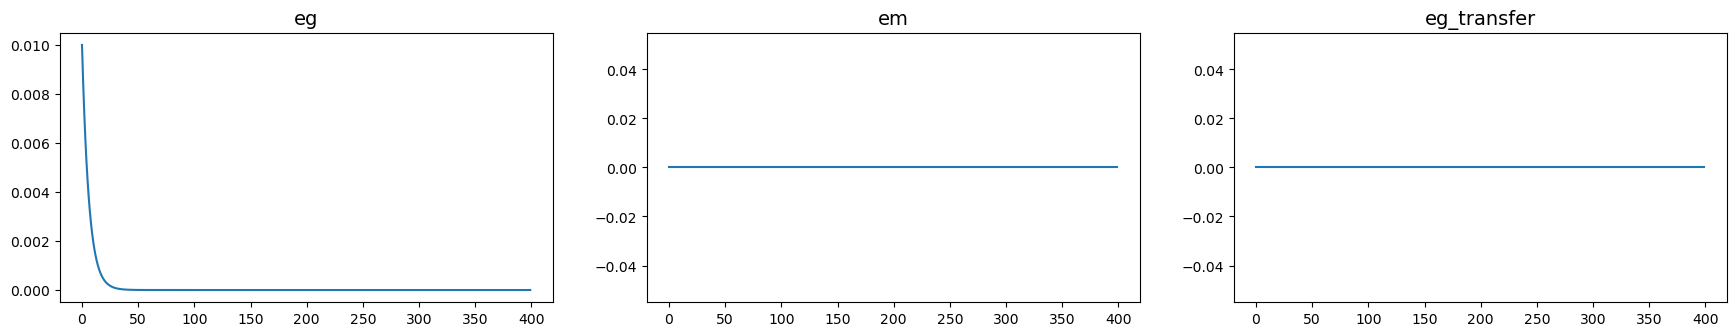


### varnames ###


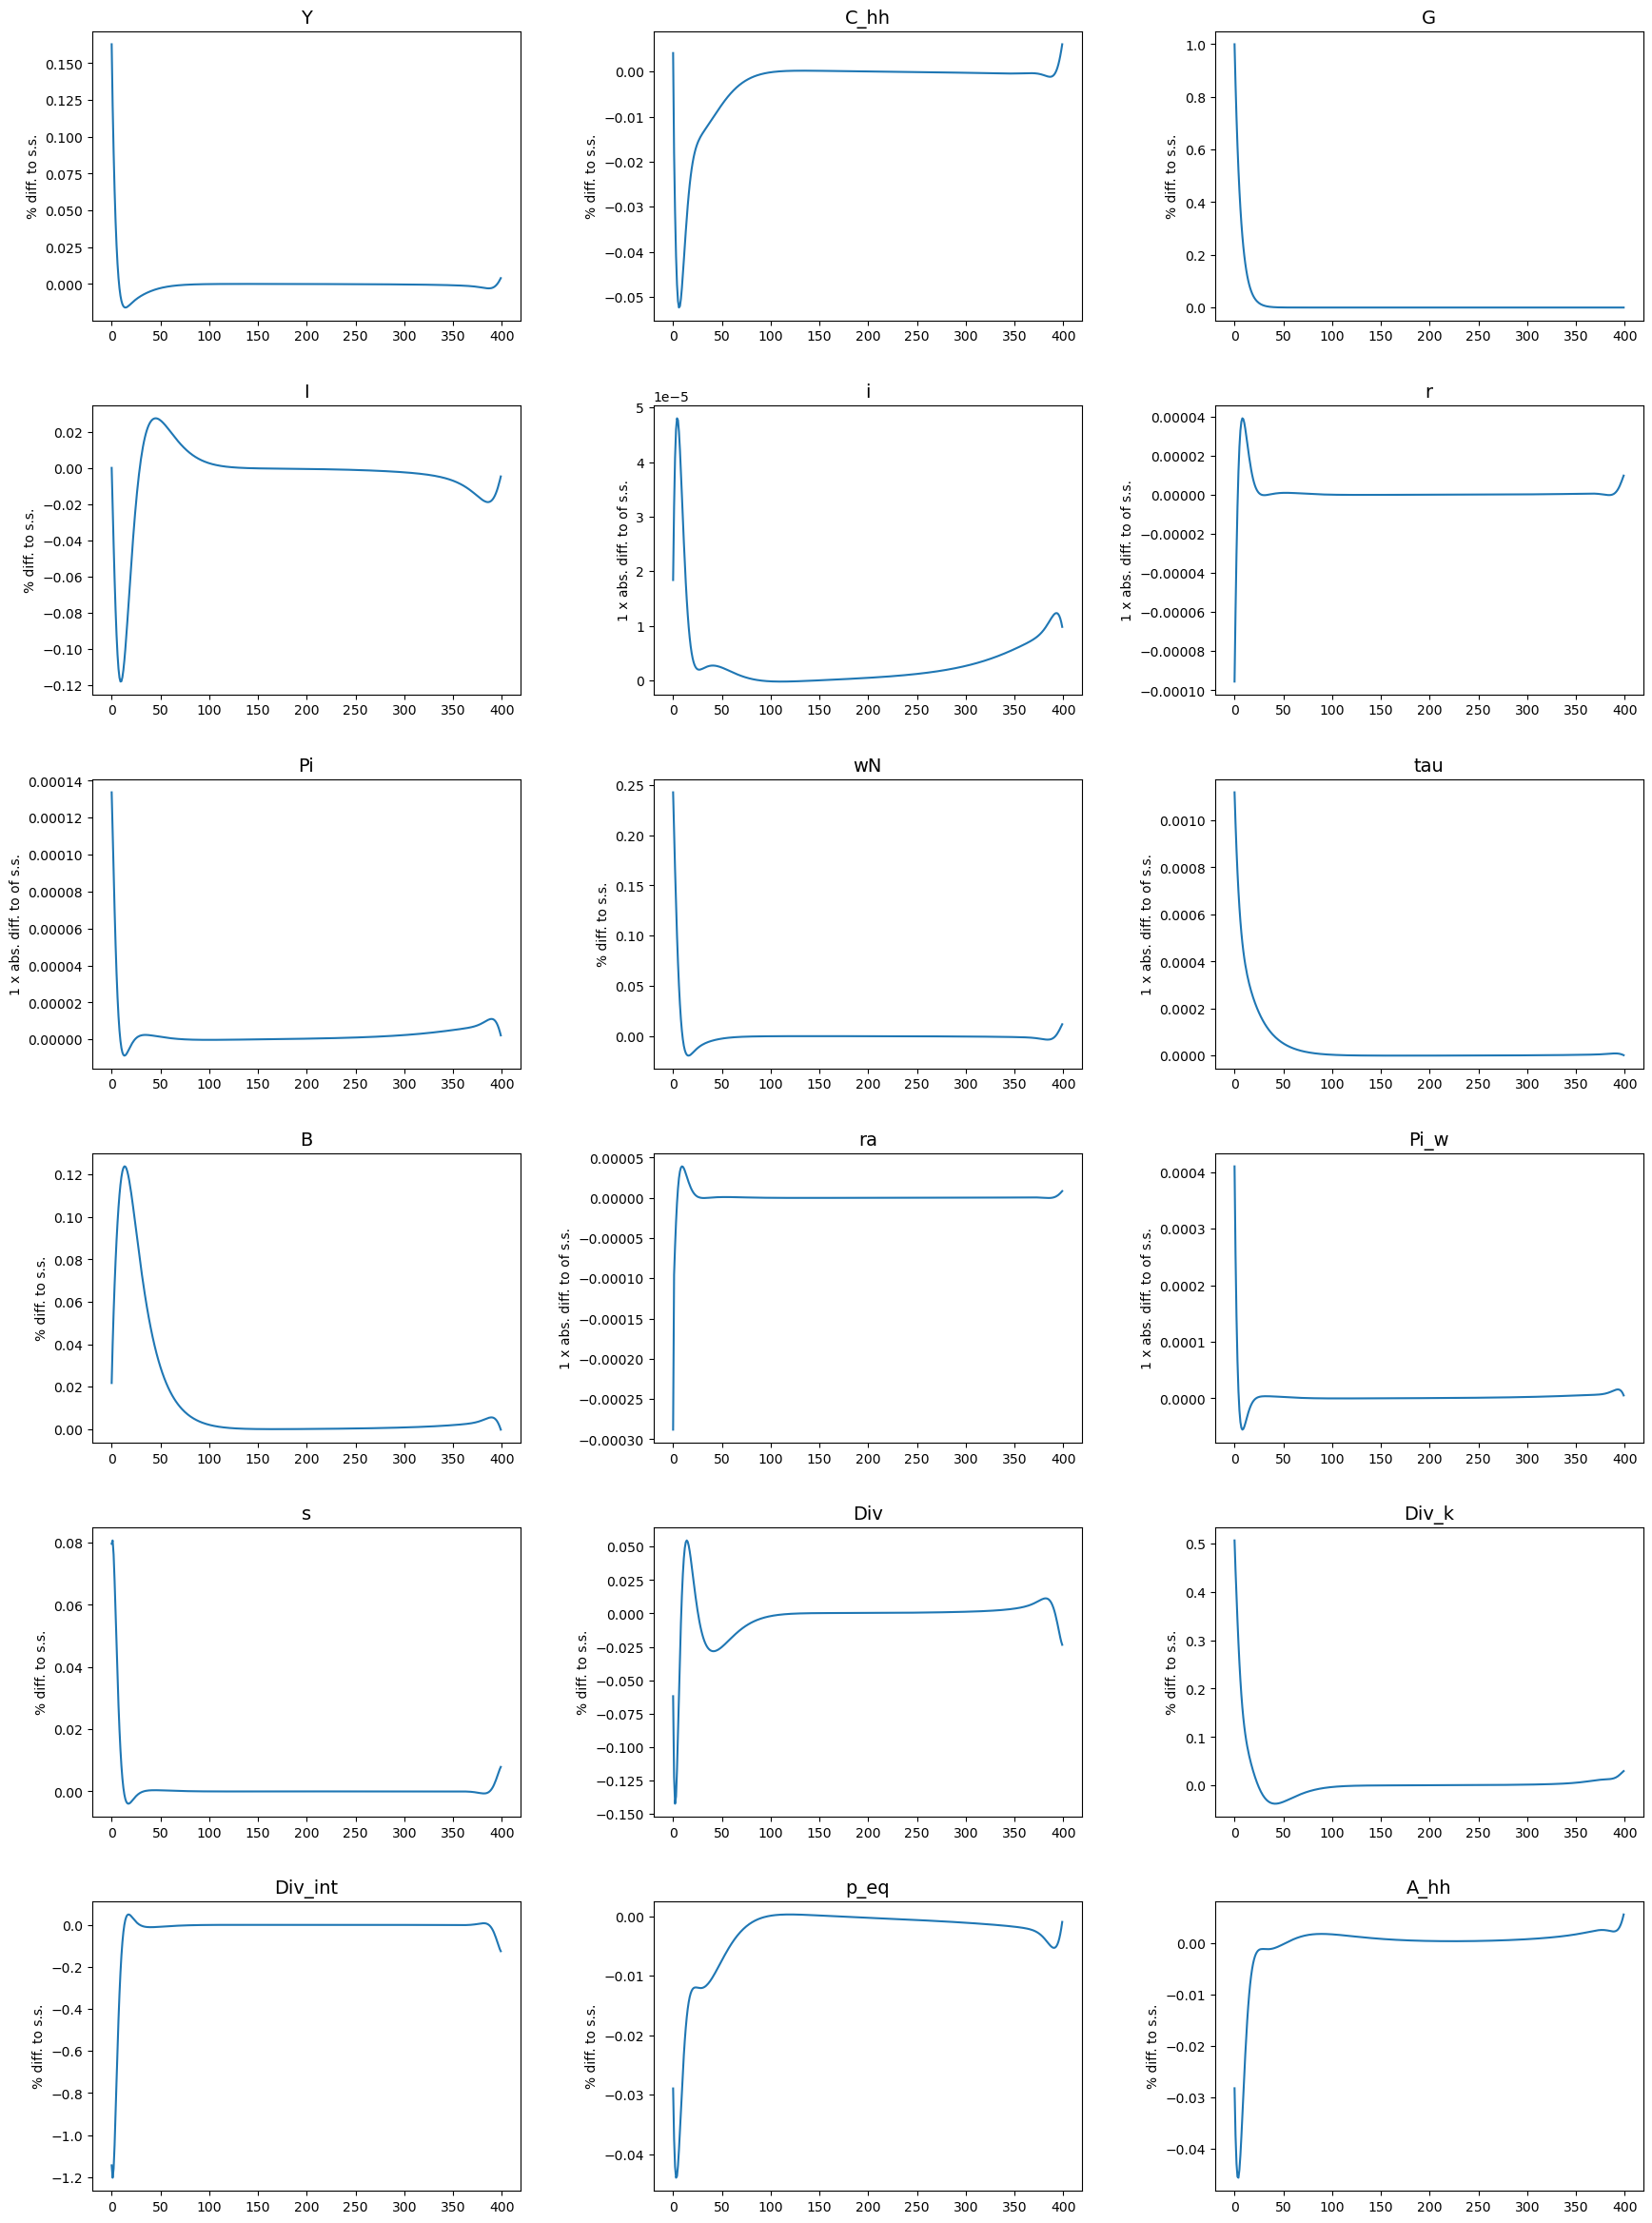

In [14]:
models = [model]
labels = ['baseline no sticky',]
paths = ['Y', 'C_hh', 'G', 'I', 'i', 'r', 'Pi', 'wN', 'tau', 'B','ra', 'Pi_w','s', 'Div', 'Div_k', 'Div_int', 'p_eq', 'A_hh']
paths_short = ['Y', 'C_hh', 'Pi']
lvl_value = ['eg', 'ez', 'em', 'eg_transfer', 'd_tau', 'd_B', 'd_G','eB','etau','eG']
abs_diff = ['tau',  'r', 'Pi', 'i', 'rk','Pi_w','ra']
# facs = {'r':100}
model.show_IRFs(paths,lvl_value=lvl_value,abs_diff=abs_diff,ncols=3,T_max=model.par.T,do_linear=True,do_shocks=True, do_non_linear=False, do_targets=False)
# model.show_IRFs(paths,lvl_value=lvl_value,abs_diff=abs_diff,ncols=3,T_max=25,do_linear=True,do_shocks=True, do_non_linear=True)

# Sensitivity phi_K

In [1]:
from HA_deviations.HANKStickyModel_no_I_change import HANKStickyModelClass

In [2]:
# model = HANKStickyModelClass(name='test')
model_no_I = HANKStickyModelClass(name='baseline_2602', par={'beta_mean': 0.9988,
                                                        'sigma_e': 0.36})
# model.load()
model_no_I.find_ss(do_print=True)

find beta for market clearing
 [beta, sigma_e] = [  0.998800000000,   0.360000000000] -> [ss.clearing_Y =   0.000231564242, ss.clearing_MPC =  -0.003893598190] [15.1 secs]
 [beta, sigma_e] = [  0.998800000000,   0.360000000000] -> [ss.clearing_Y =   0.000231564242, ss.clearing_MPC =  -0.003893598190] [9.4 secs]
 [beta, sigma_e] = [  0.998800000000,   0.360000000000] -> [ss.clearing_Y =   0.000231564242, ss.clearing_MPC =  -0.003893598190] [9.6 secs]
 [beta, sigma_e] = [  0.998800014883,   0.360000000000] -> [ss.clearing_Y =   0.000231505769, ss.clearing_MPC =  -0.003892680925] [9.8 secs]
 [beta, sigma_e] = [  0.998800000000,   0.360000005364] -> [ss.clearing_Y =   0.000231563740, ss.clearing_MPC =  -0.003893593267] [9.7 secs]
 [beta, sigma_e] = [  0.998870226555,   0.359526595375] -> [ss.clearing_Y =  -0.000003386733, ss.clearing_MPC =   0.000022871562] [10.0 secs]
 [beta, sigma_e] = [  0.998870675861,   0.359471319250] -> [ss.clearing_Y =   0.000000061321, ss.clearing_MPC =   0.000001

In [3]:
ss = model_no_I.ss
par = model_no_I.par
model_no_I._compute_jac_hh(do_print=True)
model_no_I_sticky = model.copy()
model_no_I_sticky.par.inattention = 0.935
model_no_I_sticky.jac_hh = model_sticky._compute_sticky_jacs_hh(model_no_I_sticky.jac_hh)

one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for eg_transfer     in 5.9 secs
curly_Y and curly_D calculated for ra              in 5.7 secs
curly_Y and curly_D calculated for rl              in 5.9 secs
curly_Y and curly_D calculated for tau             in 6.1 secs
curly_Y and curly_D calculated for wN              in 5.7 secs
curly_E calculated in 3.6 secs
builiding blocks combined in 2.8 secs
household Jacobian computed in 35.8 secs


In [28]:
model_no_I = model.copy()
model_no_I_sticky = model_sticky.copy()

In [35]:
model.par.phi_G = model_sticky.par.phi_G = 0.0
model.par.phi_pi = model_sticky.par.phi_pi = 1.25
model.blocks = model_sticky.blocks = [
            'blocks.production_firm',
            'blocks.capital_firm',
            'blocks.price_setters_no_indexation',
            'blocks.mutual_fund',
            'blocks.government_constant_B',
            'hh',
            'blocks.union_no_indexation',
            'blocks.taylor',
            'blocks.fisher',
            'blocks.real_wage',
            'blocks.market_clearing']
model.par.rho_eg = model_sticky.par.rho_eg = 0.9
model.par.jump_eg = model_sticky.par.jump_eg = 0.01
model.par.jump_eg_transfer = model_sticky.par.jump_eg_transfer = 0.0
model.par.jump_em = model_sticky.par.jump_em = 0.0
delta_G = model.par.jump_eg * model.par.rho_eg ** np.arange(model.par.T)
print(f'Shock with parameters jump = {model.par.jump_eg}, rho = {model.par.rho_eg} leads to a total spending increase of {delta_G.sum()*100:.2f}% over the full spending horizon')
print(f'This corresponds to {delta_G.sum()*ss.G*100:.2f}% of GDP')

Shock with parameters jump = 0.01, rho = 0.9 leads to a total spending increase of 10.00% over the full spending horizon
This corresponds to 1.60% of GDP


In [10]:
model_no_I.par.phi_G = model_no_I_sticky.par.phi_G = 0.0
model_no_I.par.phi_pi = model_no_I_sticky.par.phi_pi = 1.25
model_no_I.blocks = model_no_I_sticky.blocks = [
            'blocks.production_firm',
            'blocks.capital_firm_constant_I',
            'blocks.price_setters_no_indexation',
            'blocks.mutual_fund',
            'blocks.government_constant_B',
            'hh',
            'blocks.union_no_indexation',
            'blocks.taylor',
            'blocks.fisher',
            'blocks.real_wage',
            'blocks.market_clearing']

Shock with parameters jump = 0.01, rho = 0.9 leads to a total spending increase of 10.00% over the full spending horizon
This corresponds to 1.60% of GDP


In [11]:
IRFs_phi_K = {}
calc_jacs_IRFs(model_no_I, model_no_I_sticky, inattention_baseline = 0.935, shocks=['eg'])
IRFs_phi_K[model_no_I.par.inattention] = deepcopy(model_no_I.IRF)
IRFs_phi_K[model_no_I_sticky.par.inattention] = deepcopy(model_no_I_sticky.IRF)

Fiscal policy settings:
phi_G = 0.0
phi_tau = 0.1
phi_pi = 1.25
rho_m = 0.89

shock settings:
shock: eg -> jump = 0.01, rho = 0.9

Compute Jacobians (no sticky) 
Compute Jacobians (sticky) 
find IRFs (no sticky)
find IRFs (sticky)


In [36]:
calc_jacs_IRFs(model, model_sticky, inattention_baseline = 0.935, shocks=['eg'])
IRFs_phi_K[(model.par.inattention, 'I on')] = deepcopy(model.IRF)
IRFs_phi_K[(model_sticky.par.inattention, 'I on')] = deepcopy(model_sticky.IRF)

Fiscal policy settings:
phi_G = 0.0
phi_tau = 0.1
phi_pi = 1.25
rho_m = 0.89

shock settings:
shock: eg -> jump = 0.01, rho = 0.9

Compute Jacobians (no sticky) 
Compute Jacobians (sticky) 
find IRFs (no sticky)
find IRFs (sticky)


### shocks ###


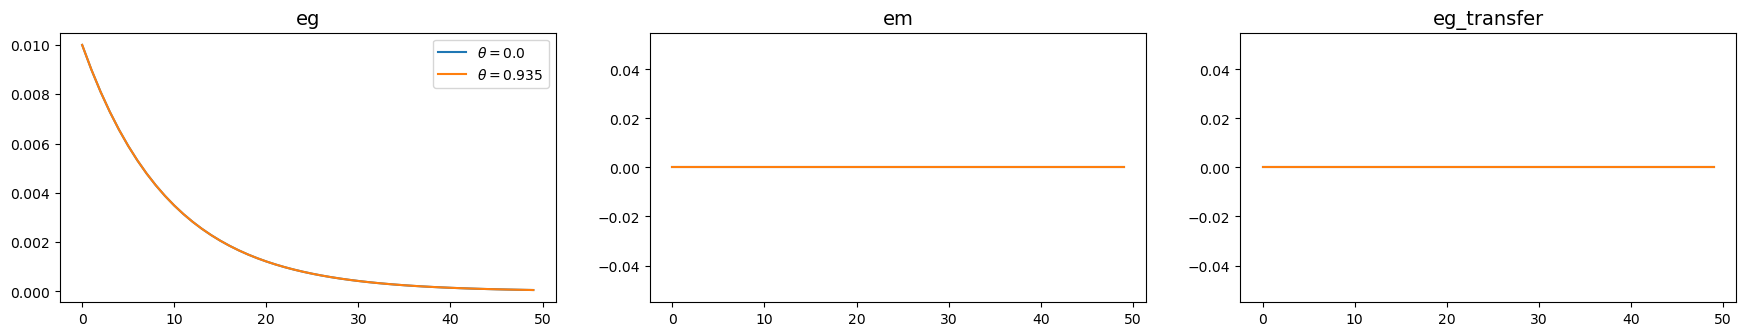


### varnames ###


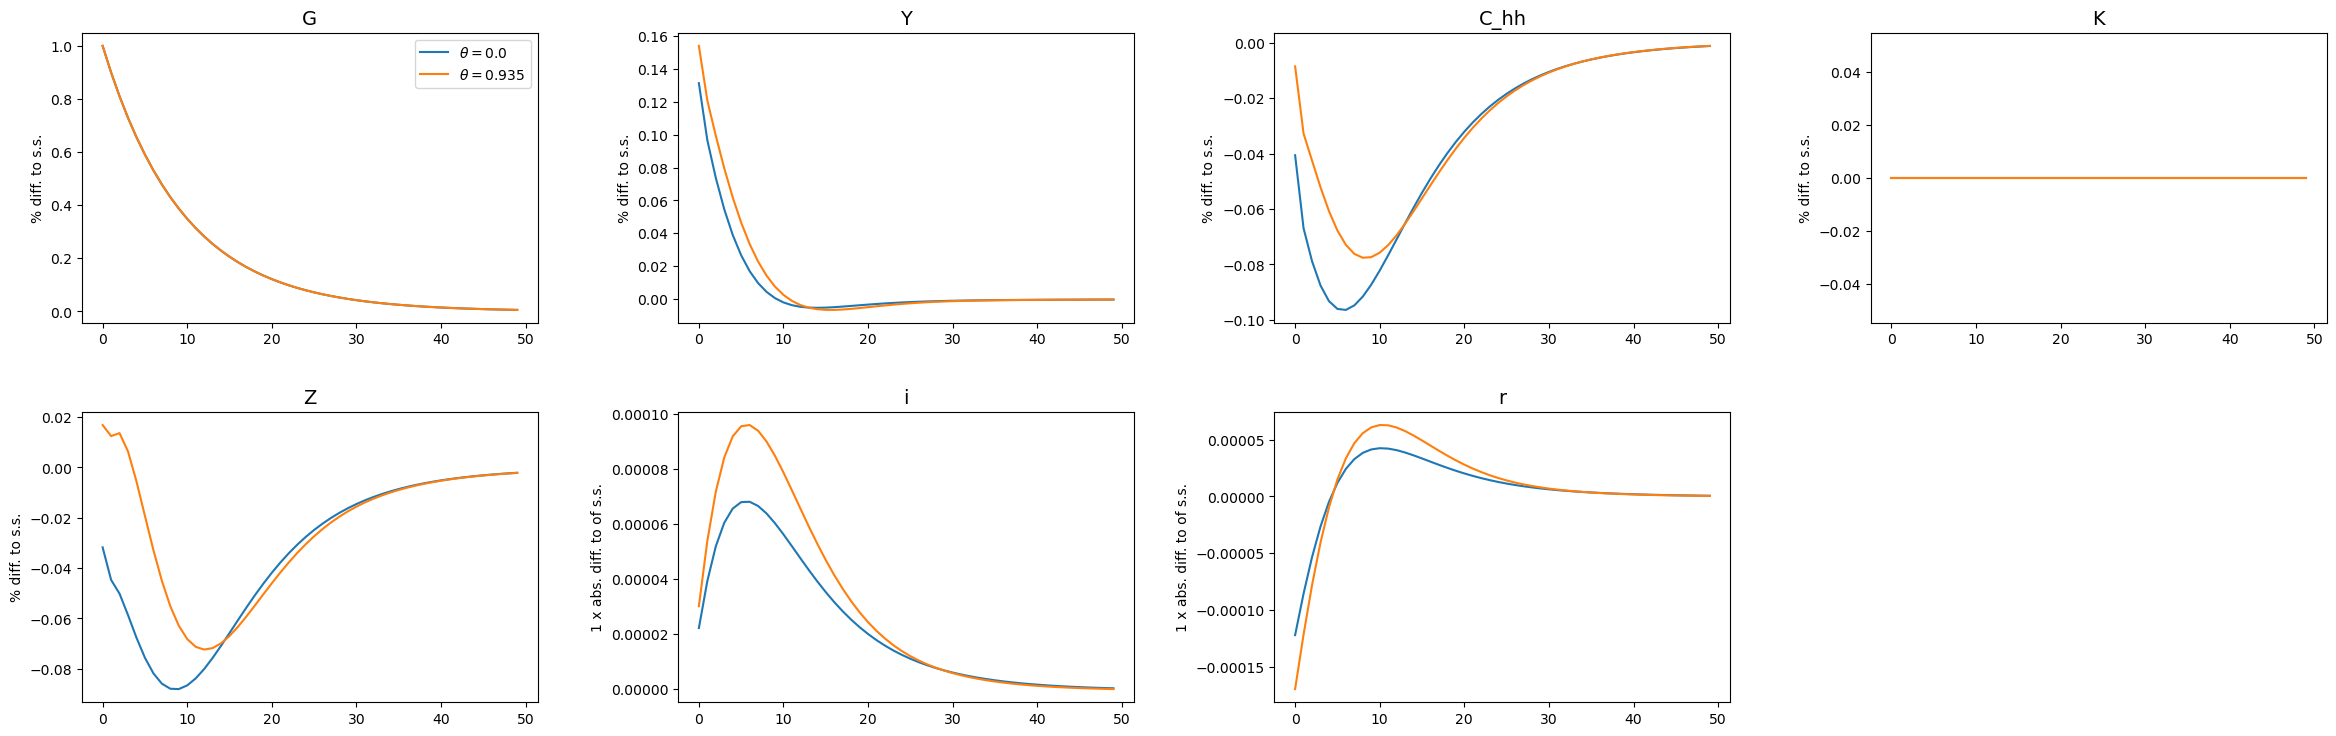


### tagets ###


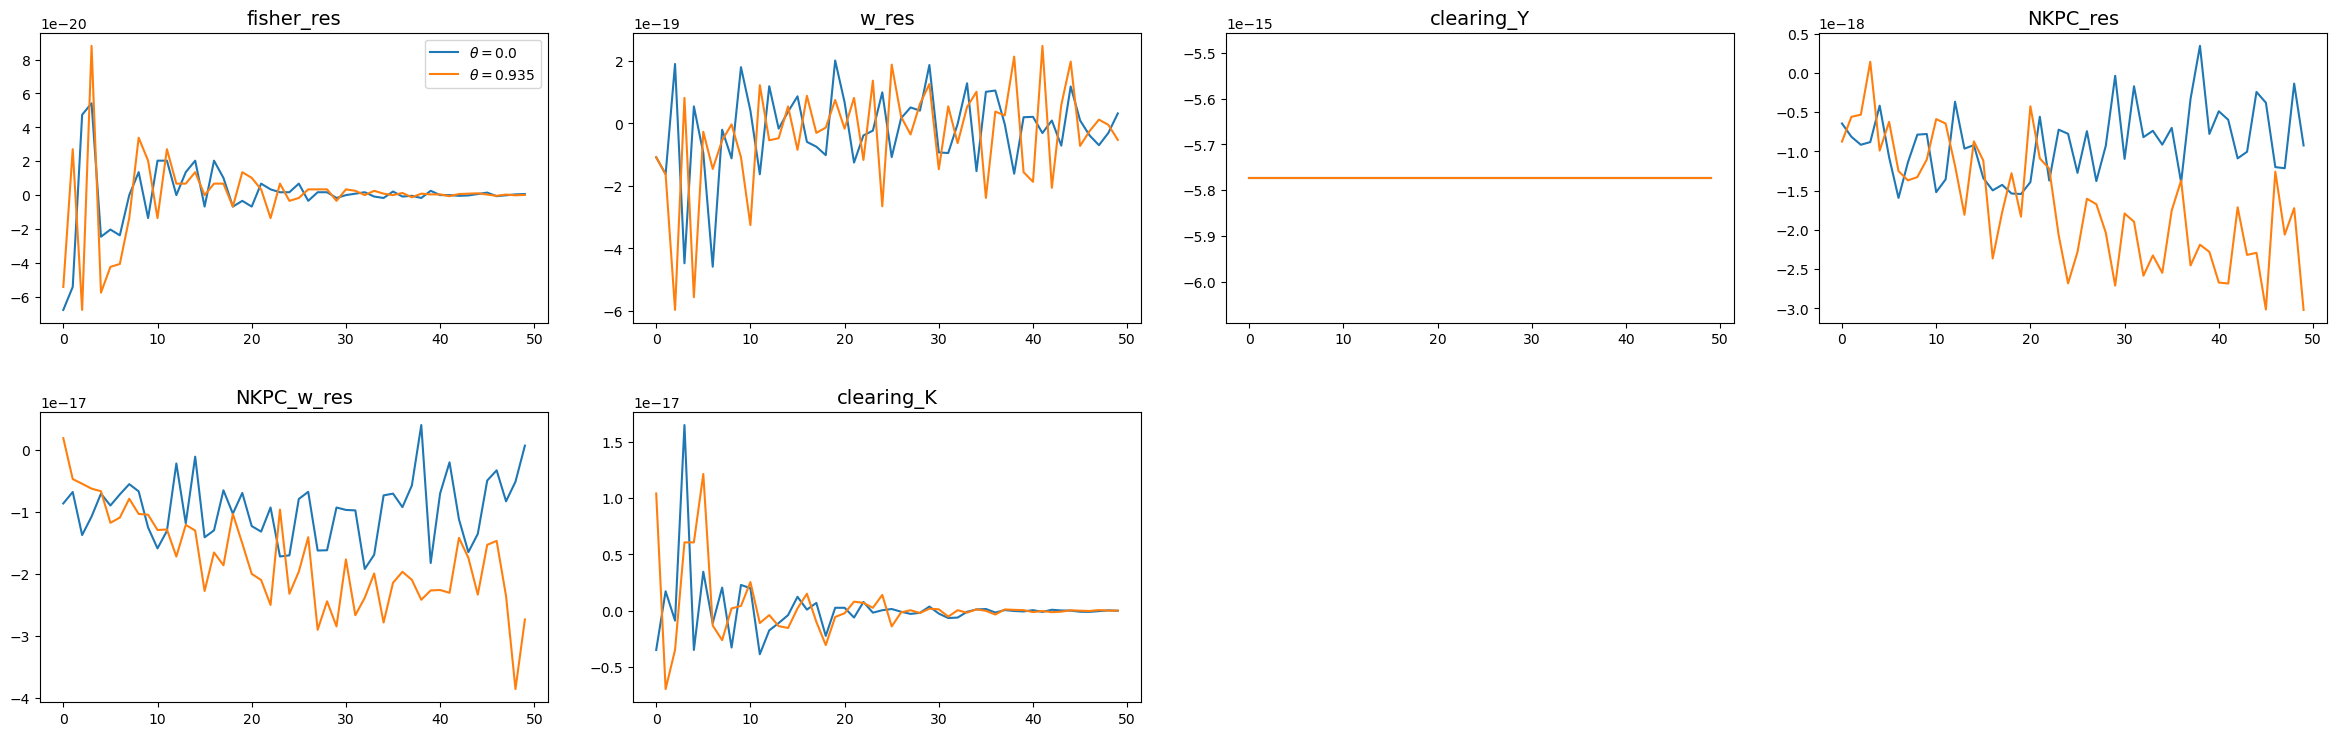

In [27]:
labels = [f'$\\theta = {model.par.inattention}$', f'$\\theta = {model_sticky.par.inattention}$']
# labels_sticky = [f'$\phi_G = {model_sticky.par.phi_G}, \\theta = {model_sticky.par.inattention}$, phi_pi = {phi_pi}' for phi_pi in phi_pis]
paths_short = ['G', 'Y', 'C_hh', 'K', 'Z', 'i','r']
paths2 = ['G', 'Y', 'C_hh', 'i', 'r', 'Pi', 'Pi_w', 'w', 'N', 'K', 's', 'rk', 'B', 'tau', 'Z']
lvl_value = ['eg', 'eg_transfer', 'em', 'Pi','Pi_w']
abs_diff = ['tau',  'r', 'Pi', 'i', 'rk', 'ra', 'Pi_w']
show_only_IRFs(model, list(IRFs_phi_K.values()), labels, paths_short, lvl_value=lvl_value, abs_diff=abs_diff, T_max=50)
# show_only_IRFs(model_sticky, list(IRFs_sticky_phi_pi.values()), labels_sticky, paths_short, lvl_value=lvl_value, abs_diff=abs_diff, T_max=50)

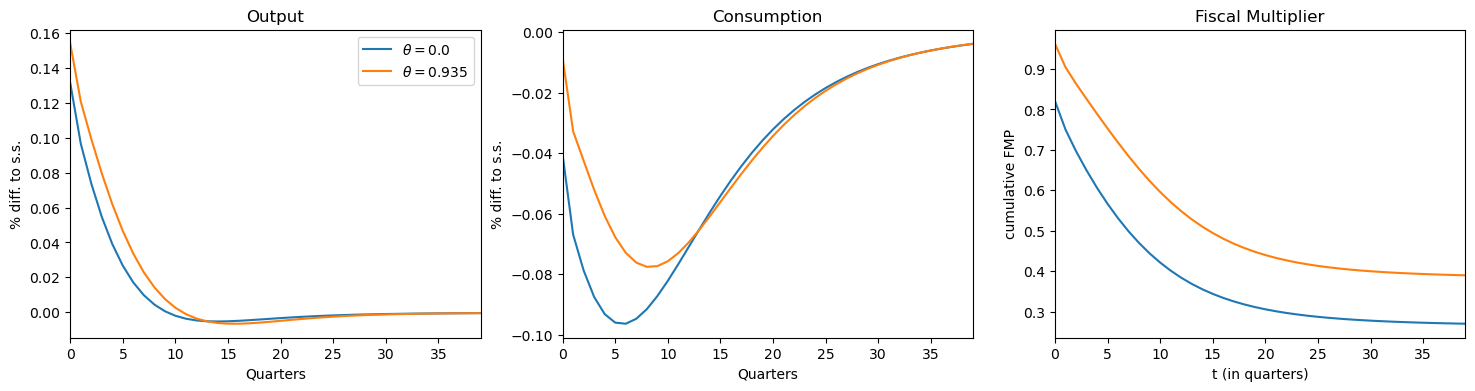

In [20]:
plot_Y_C_FMPs(IRFs_phi_K,do_transfers=False)

In [24]:
jacs_hh_thetas = {0.0: model.jac_hh,
                  0.935: model_sticky.jac_hh}

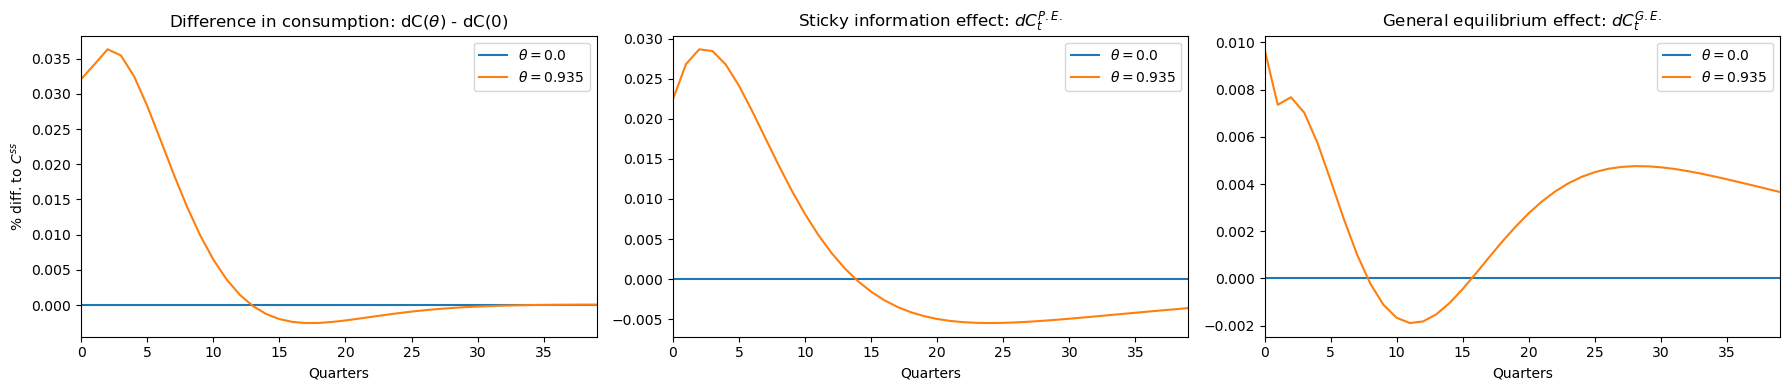

In [25]:
plot_decomp_by_thetas(IRFs_phi_K, jacs_hh_thetas, ss=model.ss, T_max=40, do_transfer=False)

Consumption increase  due to sticky information effect: 0.000247, abs.: 0.003136
Consumption increase due to G.E effect: 0.001557, abs.: 0.001800
In sum the Sticky information effect contributes 0.14 and general equilibrium effect 0.86. to consumption change
In absolute consumption the Sticky information effect contributes 0.64 and general equilibrium effect 0.36 of the consumption change.


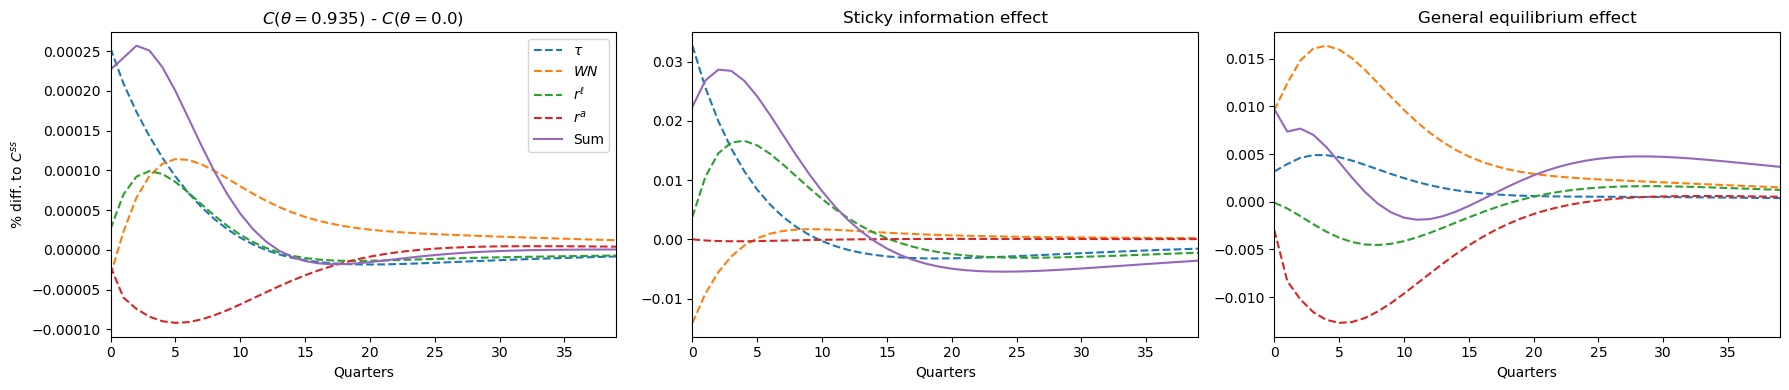

In [26]:
plot_decomp_by_inputs(IRFs_phi_K, jacs_hh_thetas, 0.935, ss=model.ss, T_max=40, do_transfer=False, use_Z=False)

In [ ]:
IRFs_phi_K[0]

### shocks ###


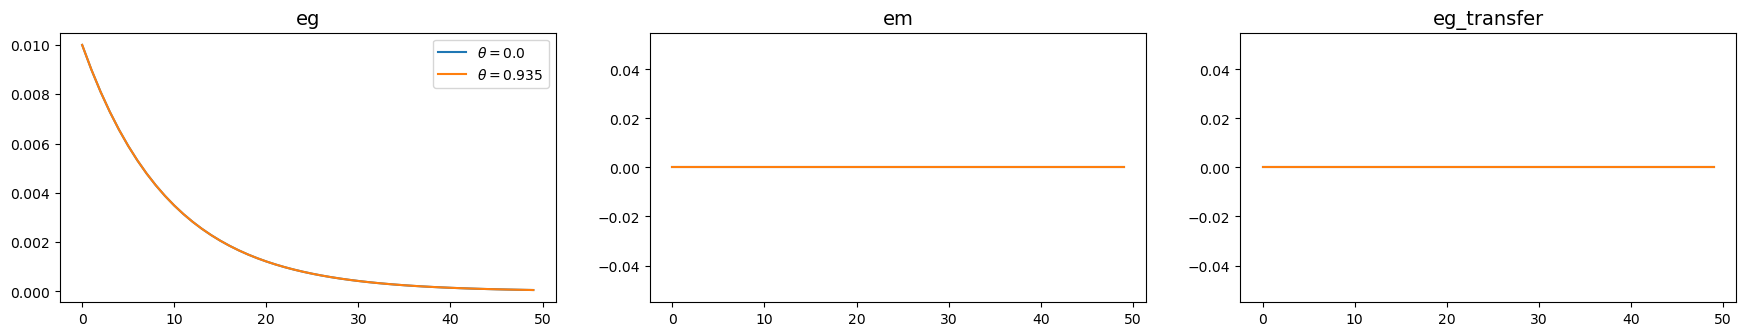


### varnames ###


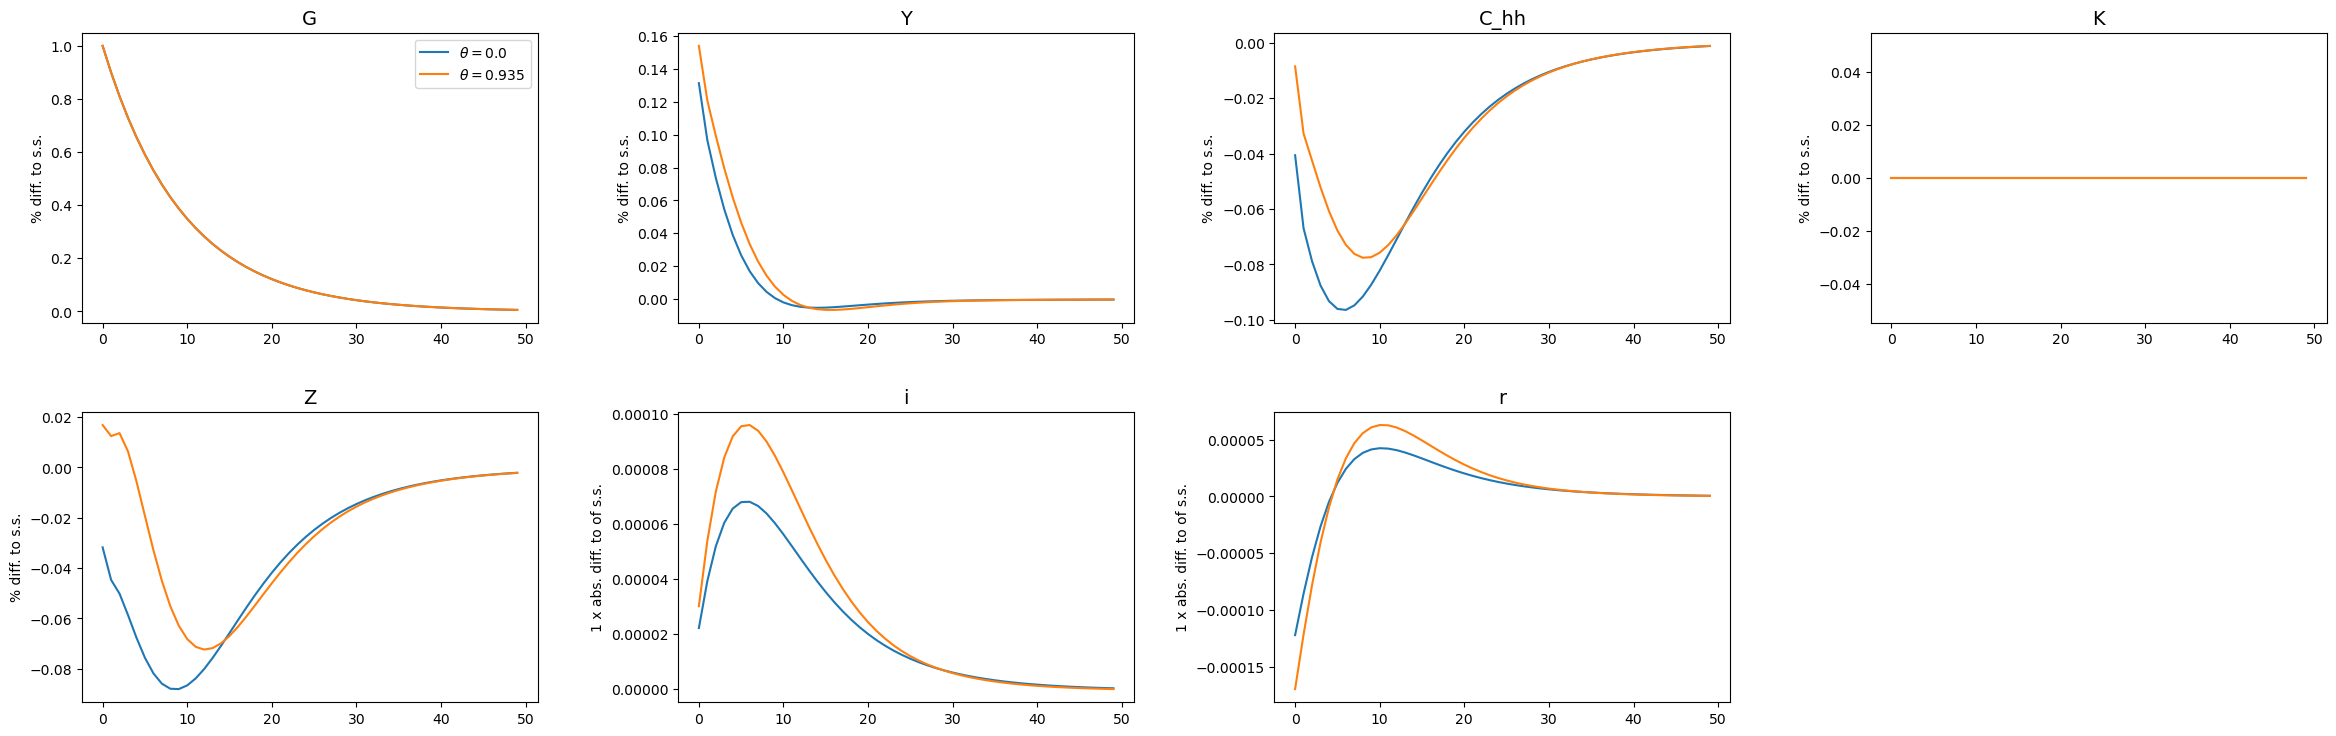


### tagets ###


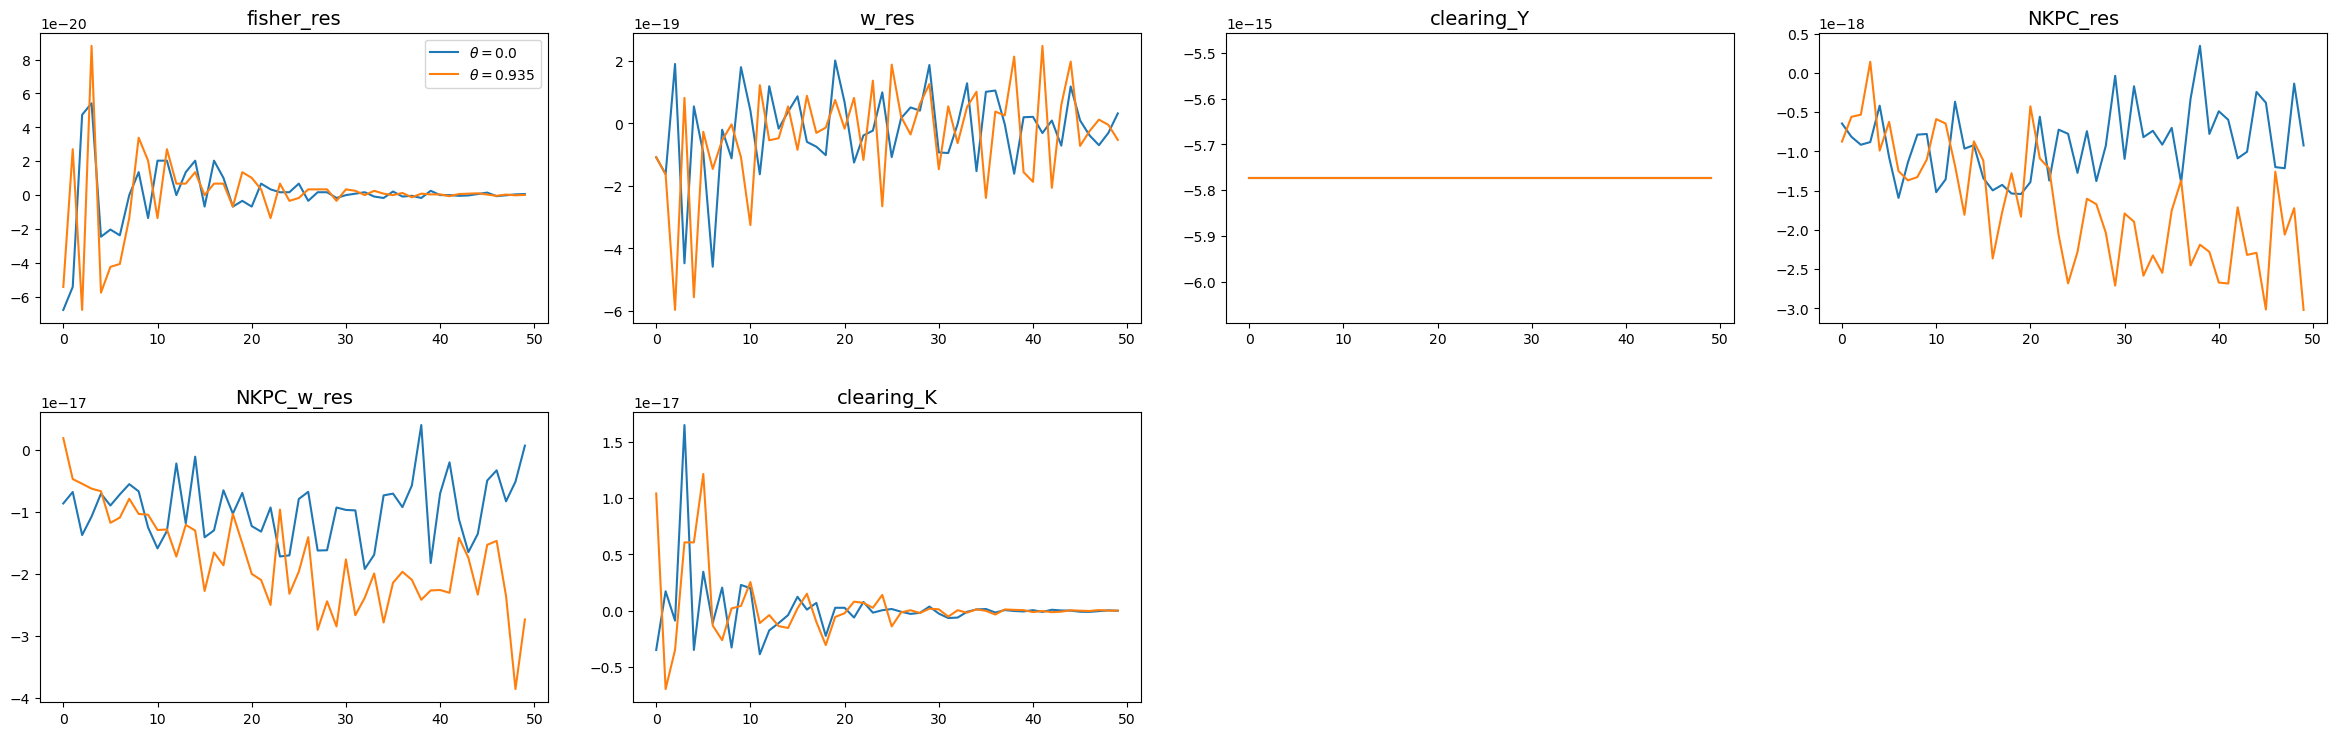

In [27]:
labels = [f'$\\theta = {model.par.inattention}, \\phi_K = \\infty$', f'$\\theta = {model_sticky.par.inattention}, \\phi_K = \\infty$', f'$\\theta = {model.par.inattention}, \\phi_K = {model_sticky.par.phi_K}$', f'$\\theta = {model_sticky.par.inattention}, \\phi_K = {model_sticky.par.phi_K}$']
# labels_sticky = [f'$\phi_G = {model_sticky.par.phi_G}, \\theta = {model_sticky.par.inattention}$, phi_pi = {phi_pi}' for phi_pi in phi_pis]
paths_short = ['G', 'Y', 'C_hh', 'K', 'Z', 'i','r']
paths2 = ['G', 'Y', 'C_hh', 'i', 'r', 'Pi', 'Pi_w', 'w', 'N', 'K', 's', 'rk', 'B', 'tau', 'Z']
lvl_value = ['eg', 'eg_transfer', 'em', 'Pi','Pi_w']
abs_diff = ['tau',  'r', 'Pi', 'i', 'rk', 'ra', 'Pi_w']
show_only_IRFs(model, list(IRFs_phi_K.values()), labels, paths_short, lvl_value=lvl_value, abs_diff=abs_diff, T_max=50)
# show_only_IRFs(model_sticky, list(IRFs_sticky_phi_pi.values()), labels_sticky, paths_short, lvl_value=lvl_value, abs_diff=abs_diff, T_max=50)

In [40]:
IRFs_phi_K_compare = {(model_no_I.par.inattention, 'fix-I'): deepcopy(model_no_I.IRF),
                      (model_no_I_sticky.par.inattention, 'fix-I'): deepcopy(model_no_I_sticky.IRF),
                      model.par.inattention: deepcopy(model.IRF),
                      model_sticky.par.inattention: deepcopy(model_sticky.IRF)}

In [42]:
jacs_hh_thetas = {(model_no_I.par.inattention, 'fix-I'): model.jac_hh,
                  (model_no_I_sticky.par.inattention, 'fix-I'): model_sticky.jac_hh,
                  model.par.inattention: model.jac_hh,
                  model_sticky.par.inattention: model_sticky.jac_hh}

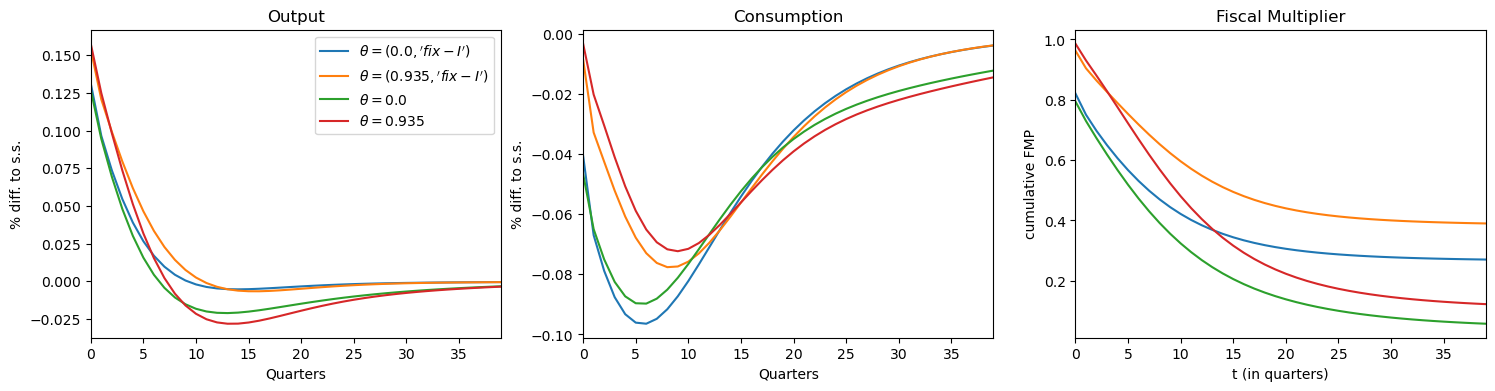

In [41]:
plot_Y_C_FMPs(IRFs_phi_K_compare,do_transfers=False)

KeyError: (0.0, 'I on')

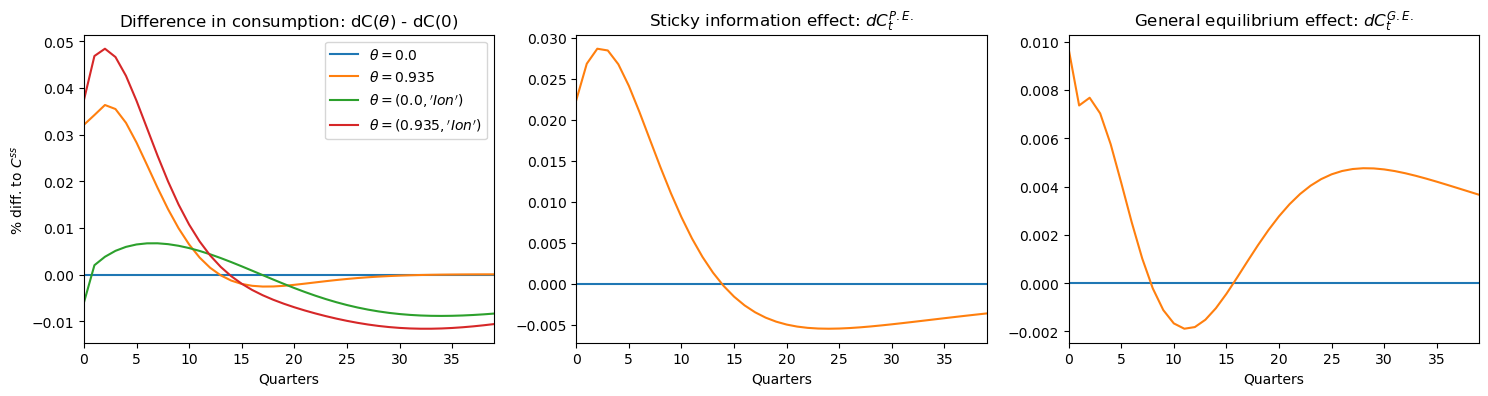

In [43]:
plot_decomp_by_thetas(IRFs_phi_K, jacs_hh_thetas, ss=model.ss, T_max=40, do_transfer=False)

Consumption increase  due to sticky information effect: 0.000247, abs.: 0.003136
Consumption increase due to G.E effect: 0.001557, abs.: 0.001800
In sum the Sticky information effect contributes 0.14 and general equilibrium effect 0.86. to consumption change
In absolute consumption the Sticky information effect contributes 0.64 and general equilibrium effect 0.36 of the consumption change.


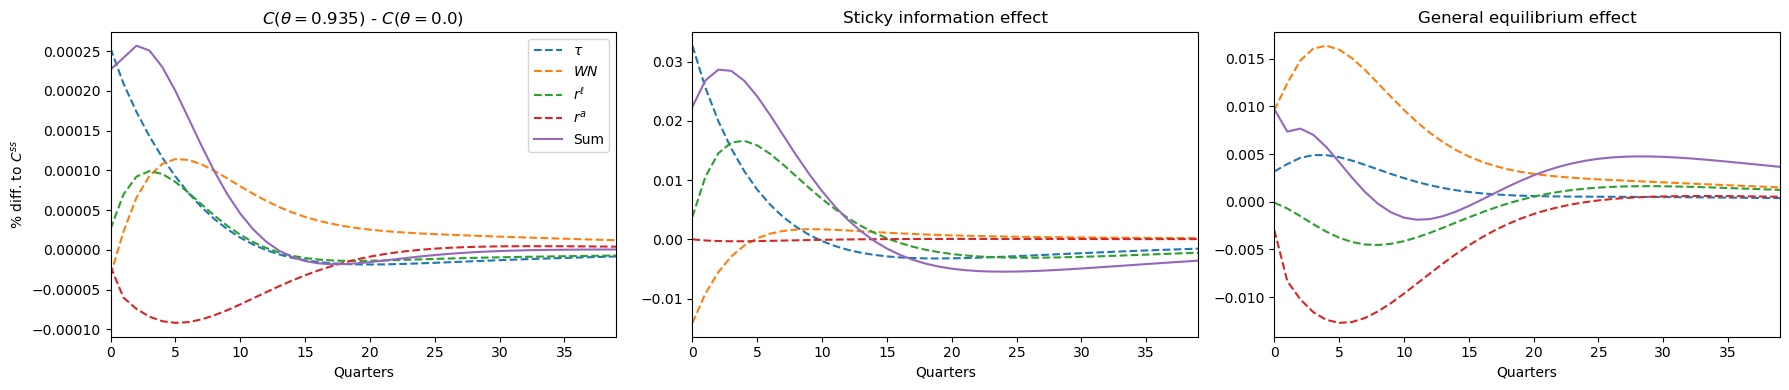

In [44]:
plot_decomp_by_inputs(IRFs_phi_K, jacs_hh_thetas, 0.935, ss=model.ss, T_max=40, do_transfer=False, use_Z=False)